# Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# filtering messages to error
import warnings

warnings.filterwarnings('ignore')

# Utils

In [3]:
def read_file(filename):
    tmp = list()
    with open(filename) as f:
        for line in f:
            if len(line.rstrip()) == 0:
                continue
            tmp.append([float(i) for i in line.rstrip().split(',')])
    return tmp

## Graphs

In [4]:
def draw_graph(values, algorithm, title, y_label, errors=False, single_tech=False):

    score, std = values
    
    '''
        The lists have the following format:
        
        list = [
            [
                [],  # random-forest
                [],  # gradient-boosting
                [],  # logistic-regression
                [],  # mvc
                []   # mlp
            ],  # active-semi 
            [ ... ],  # active-super
            [ ... ],  # random-semi
            [ ... ]   # random-super
        ]
    '''
    
    _score = [i[algorithm] for i in score]
    _std   = [i[algorithm] for i in std]
    
    _labels = TECHS
    
    if single_tech:
        _score = score[algorithm]
        _std = std[algorithm]
        
        _labels = LEARNERS

    fig, ax = plt.subplots(figsize=(8, 6))
    
    if errors:
        # show error bars
        for y, std, label in zip(_score, _std, _labels):
            errors = [np.array(y) - np.array(std), np.array(y) + np.array(std)]
            ax.errorbar(RANGES, y, yerr=errors, fmt='-', alpha=0.9, capsize=4, label=label)
    else:
        for y, label in zip(_score, _labels):
            ax.plot(RANGES, y, label=label)
        
    ax.set_title(title, size=12)
    ax.set_xlabel('number of elements', size=12)
    ax.set_ylabel(y_label, size=12)
    ax.grid(color='0.95')
    ax.legend()

In [5]:
def plot_confusion_matrix(cms, tech, algo):
    
    labels = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']
    titles = ['#00 elem.', 'Mean', '#80 elem.']
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    
    fig.suptitle(f'{TECHS[tech]} - {LEARNERS[algo].upper()} CM', size=14)
    
    for index, (axe, cm_values, title) in enumerate(zip(axes, cms, titles)):
        cm = np.ndarray(shape=(4,4), dtype=float)
        begin = 0
        for row in range(4):           
            cm[row, ] = cm_values[tech][algo][begin:begin + 4]
            begin += 4
        
        yticks = labels if index == 0 else False
        draw_cbar = True if index == 2 else False
        
        axe.set_title(title)
        axe = sns.heatmap(cm, ax=axe, annot=True, fmt=".2f", linewidths=.5, cmap=plt.cm.Blues, 
                          yticklabels=yticks, xticklabels=labels, cbar=draw_cbar)
        
        axe.set_xticklabels(axe.get_xticklabels(), rotation=45)
        axe.set_yticklabels(axe.get_yticklabels(), rotation=0)
    plt.show()

In [6]:
def find_best_classifier(accs):
    classifiers_names = ['rf', 'gb', 'lr', 'svc', 'mlp']

    for i, n_elem in enumerate(RANGES):
        best_tech = ''
        best_classifier = ''
        max_acc = 0
        for test_index, classifiers in enumerate(accs):
            for learner_index, classifier in enumerate(classifiers):
                curr_acc = classifier[i]
                if curr_acc > max_acc:
                    max_acc = curr_acc
                    best_tech = FILES[test_index]
                    best_classifier = LEARNERS[learner_index]
                    
        if i % 10 == 0 or i == len(RANGES) - 1:
            print(f'For #{n_elem} elements, the best classifier is {best_classifier.upper()} using {best_tech} with {max_acc:.2f} score.')

In [7]:
def print_statistics(accs, index):
    learner_results = [i[index] for i in accs]
    for n_elem, size in enumerate(RANGES):
       
        curr_acc = [i[n_elem] for i in learner_results ]
        best = TECHS[curr_acc.index(max(curr_acc))]
        
        if n_elem % 10 == 0 or n_elem == len(RANGES) - 1:
            print(f'#{size} elements: max acc = {max(curr_acc):.2f} => best: {best}')

## Results

In [8]:
FILES = ['active-semi', 'active-super', 'random-semi', 'random-super']

In [9]:
LEARNERS = ['rf', 'gb', 'lr', 'svc', 'mlp']

In [10]:
TECHS = ['Active Semi-supervised', 'Active Supervised', 'Random Semi-supervised', 'Random Supervised']

In [11]:
RANGES = [i for i in range(100)]

In [12]:
ACTIVE_SEMI = 0
ACTIVE_SUPER = 1
RANDOM_SEMI = 2
RANDOM_SUPER = 3

RF = 0
GB = 1
LR = 2
SVC = 3
MLP = 4

In [13]:
results_path = '../results/compiled'

In [14]:
# initializing lists

accs, accs_std = list(), list()
times, times_std = list(), list()

precisions, precisions_std = list(), list()
recalls, recalls_std = list(), list()
f1s, f1s_std = list(), list()

cms, cms_lower, cms_upper = list(), list(), list()

In [15]:
# reading results from file

for file in FILES:
    
    base_url = f'{results_path}/{file}'
    
    accs.append(read_file(f'{base_url}-accs-mean.txt'))
    accs_std.append(read_file(f'{base_url}-accs-std.txt'))

    times.append(read_file(f'{base_url}-times-mean.txt'))
    times_std.append(read_file(f'{base_url}-times-std.txt'))

    precisions.append(read_file(f'{base_url}-precisions-mean.txt'))
    precisions_std.append(read_file(f'{base_url}-precisions-std.txt'))

    recalls.append(read_file(f'{base_url}-recalls-mean.txt'))
    recalls_std.append(read_file(f'{base_url}-recalls-std.txt'))

    f1s.append(read_file(f'{base_url}-f1s-mean.txt'))
    f1s_std.append(read_file(f'{base_url}-f1s-std.txt'))

    cms.append(read_file(f'{base_url}-cms-mean.txt'))
    cms_lower.append(read_file(f'{base_url}-cms-lower.txt'))
    cms_upper.append(read_file(f'{base_url}-cms-upper.txt'))

In [16]:
# creating scores lists

acc_list = [accs, accs_std]
time_list = [times, times_std]

precision_list = [precisions, precisions_std]
recall_list = [recalls, recalls_std]
f1_list = [f1s, f1s_std]

cm_list = [cms_lower, cms, cms_upper]

## RF Classifier

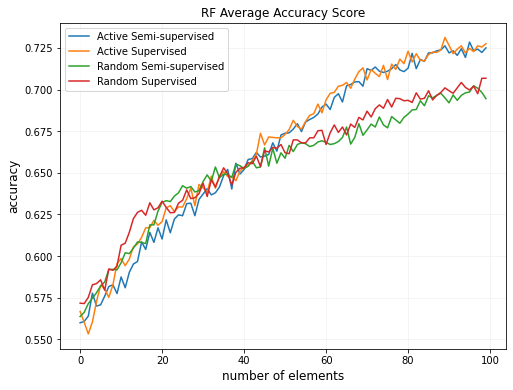

In [17]:
draw_graph(acc_list, algorithm=RF, title='RF Average Accuracy Score', y_label='accuracy')

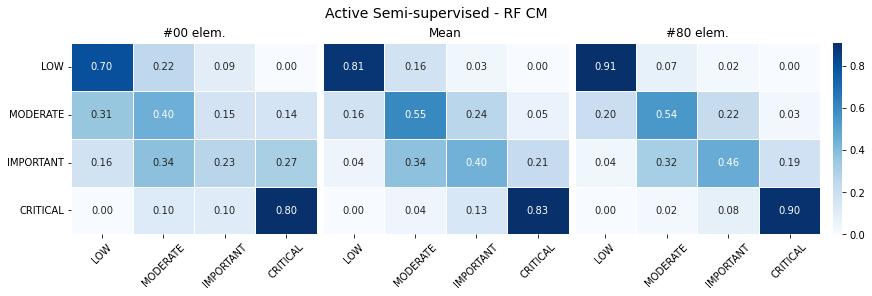

In [18]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SEMI, algo=RF)

In [19]:
print_statistics(accs, RF)

#0 elements: max acc = 0.57 => best: Random Supervised
#10 elements: max acc = 0.61 => best: Random Supervised
#20 elements: max acc = 0.63 => best: Random Supervised
#30 elements: max acc = 0.64 => best: Random Semi-supervised
#40 elements: max acc = 0.65 => best: Active Supervised
#50 elements: max acc = 0.67 => best: Active Semi-supervised
#60 elements: max acc = 0.69 => best: Active Supervised
#70 elements: max acc = 0.71 => best: Active Semi-supervised
#80 elements: max acc = 0.72 => best: Active Supervised
#90 elements: max acc = 0.73 => best: Active Supervised
#99 elements: max acc = 0.73 => best: Active Supervised


## GB Classifier

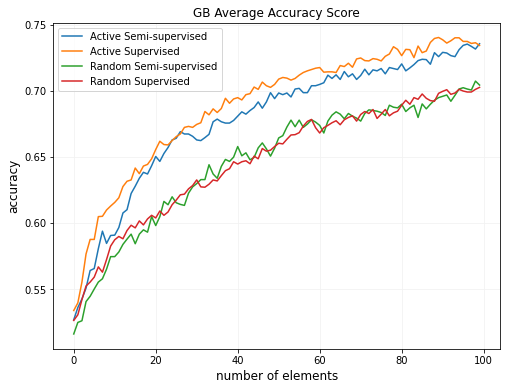

In [20]:
draw_graph(acc_list, algorithm=GB, title='GB Average Accuracy Score', y_label='accuracy')

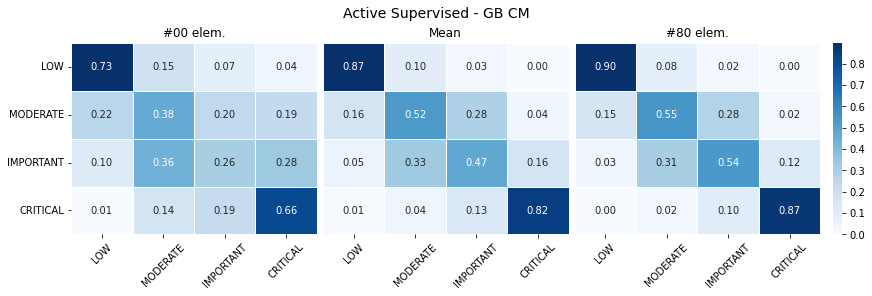

In [21]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=GB)

In [22]:
print_statistics(accs, GB)

#0 elements: max acc = 0.53 => best: Active Supervised
#10 elements: max acc = 0.62 => best: Active Supervised
#20 elements: max acc = 0.66 => best: Active Supervised
#30 elements: max acc = 0.67 => best: Active Supervised
#40 elements: max acc = 0.69 => best: Active Supervised
#50 elements: max acc = 0.71 => best: Active Supervised
#60 elements: max acc = 0.72 => best: Active Supervised
#70 elements: max acc = 0.72 => best: Active Supervised
#80 elements: max acc = 0.73 => best: Active Supervised
#90 elements: max acc = 0.74 => best: Active Supervised
#99 elements: max acc = 0.74 => best: Active Semi-supervised


## LR Classifier

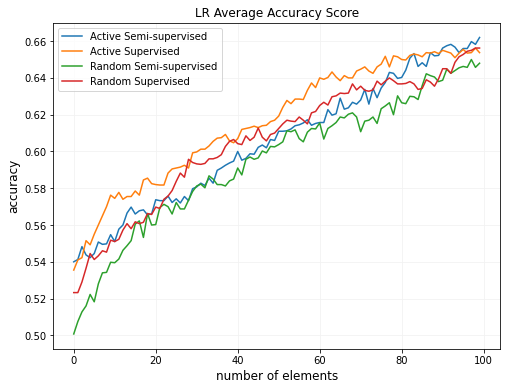

In [23]:
draw_graph(acc_list, algorithm=LR, title='LR Average Accuracy Score', y_label='accuracy')

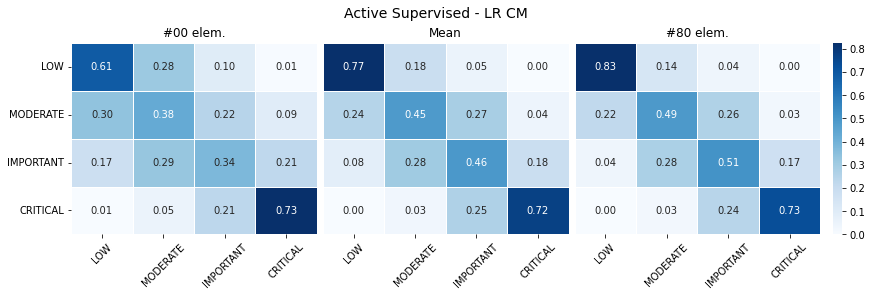

In [24]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=LR)

In [25]:
print_statistics(accs, LR)

#0 elements: max acc = 0.54 => best: Active Semi-supervised
#10 elements: max acc = 0.57 => best: Active Supervised
#20 elements: max acc = 0.58 => best: Active Supervised
#30 elements: max acc = 0.60 => best: Active Supervised
#40 elements: max acc = 0.61 => best: Active Supervised
#50 elements: max acc = 0.62 => best: Active Supervised
#60 elements: max acc = 0.64 => best: Active Supervised
#70 elements: max acc = 0.64 => best: Active Supervised
#80 elements: max acc = 0.65 => best: Active Supervised
#90 elements: max acc = 0.66 => best: Active Semi-supervised
#99 elements: max acc = 0.66 => best: Active Semi-supervised


## SVC Classifier

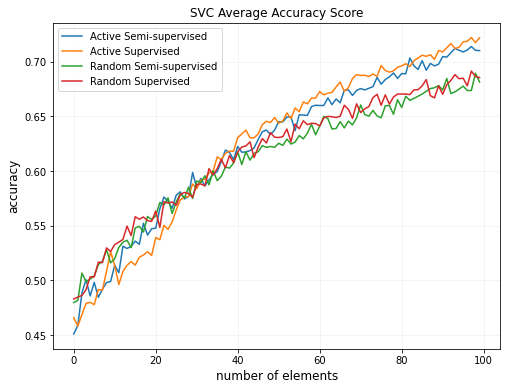

In [26]:
draw_graph(acc_list, algorithm=SVC, title='SVC Average Accuracy Score', y_label='accuracy')

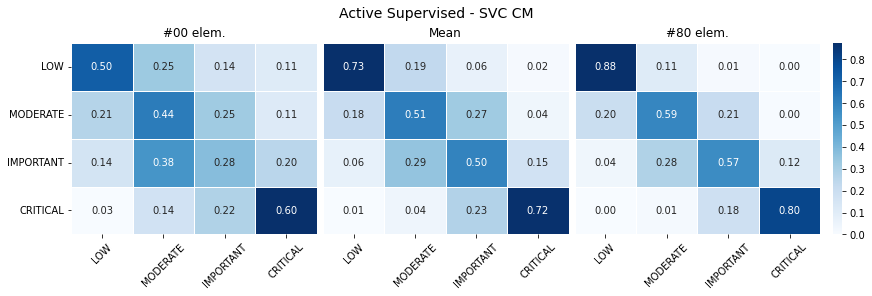

In [27]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=SVC)

In [28]:
print_statistics(accs, SVC)

#0 elements: max acc = 0.48 => best: Random Supervised
#10 elements: max acc = 0.53 => best: Random Supervised
#20 elements: max acc = 0.56 => best: Random Supervised
#30 elements: max acc = 0.59 => best: Random Semi-supervised
#40 elements: max acc = 0.63 => best: Active Supervised
#50 elements: max acc = 0.65 => best: Active Semi-supervised
#60 elements: max acc = 0.67 => best: Active Supervised
#70 elements: max acc = 0.69 => best: Active Supervised
#80 elements: max acc = 0.70 => best: Active Supervised
#90 elements: max acc = 0.71 => best: Active Supervised
#99 elements: max acc = 0.72 => best: Active Supervised


## MLP Classifier

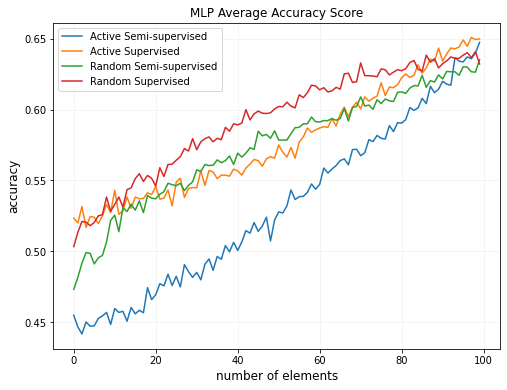

In [29]:
draw_graph(acc_list, algorithm=MLP, title='MLP Average Accuracy Score', y_label='accuracy')

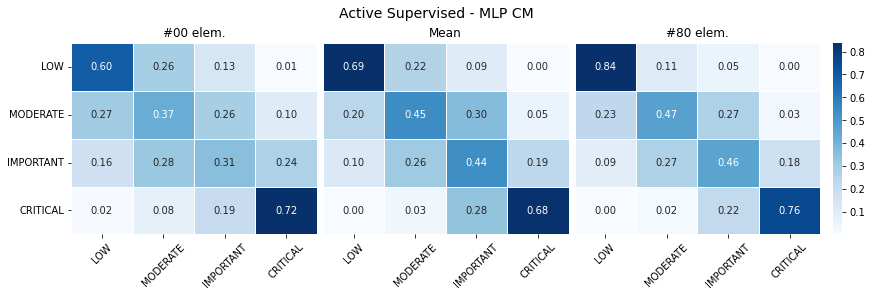

In [30]:
plot_confusion_matrix(cm_list, tech=ACTIVE_SUPER, algo=MLP)

In [31]:
print_statistics(accs, MLP)

#0 elements: max acc = 0.52 => best: Active Supervised
#10 elements: max acc = 0.54 => best: Active Supervised
#20 elements: max acc = 0.55 => best: Random Supervised
#30 elements: max acc = 0.57 => best: Random Supervised
#40 elements: max acc = 0.59 => best: Random Supervised
#50 elements: max acc = 0.60 => best: Random Supervised
#60 elements: max acc = 0.61 => best: Random Supervised
#70 elements: max acc = 0.63 => best: Random Supervised
#80 elements: max acc = 0.63 => best: Random Supervised
#90 elements: max acc = 0.63 => best: Active Supervised
#99 elements: max acc = 0.65 => best: Active Supervised


## Global statistics

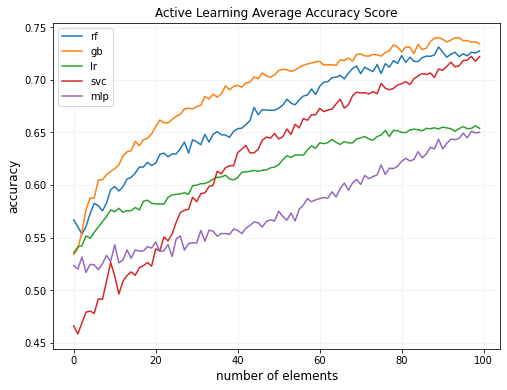

In [32]:
draw_graph(acc_list, algorithm=ACTIVE_SUPER, 
           title='Active Learning Average Accuracy Score', y_label='accuracy', 
           errors=False, single_tech=True)

In [33]:
find_best_classifier(accs)

For #0 elements, the best classifier is RF using random-super with 0.57 score.
For #10 elements, the best classifier is GB using active-super with 0.62 score.
For #20 elements, the best classifier is GB using active-super with 0.66 score.
For #30 elements, the best classifier is GB using active-super with 0.67 score.
For #40 elements, the best classifier is GB using active-super with 0.69 score.
For #50 elements, the best classifier is GB using active-super with 0.71 score.
For #60 elements, the best classifier is GB using active-super with 0.72 score.
For #70 elements, the best classifier is GB using active-super with 0.72 score.
For #80 elements, the best classifier is GB using active-super with 0.73 score.
For #90 elements, the best classifier is GB using active-super with 0.74 score.
For #99 elements, the best classifier is GB using active-semi with 0.74 score.


# Thesis Graphs and Tables

In [34]:
techs = [ACTIVE_SEMI, RANDOM_SEMI, ACTIVE_SUPER, RANDOM_SUPER]
techs_names = ['active-semi', 'random-semi', 'active-super', 'random-super']

learners = [RF, GB, LR, SVC, MLP]
learners_names = ['rf', 'gb', 'lr', 'svc', 'mlp']

for learner, learner_name in zip(learners, learners_names):
    string = f'\\textbf{{{learner_name.upper()}}} & '
    for tech, tech_name in zip(techs, techs_names):
        string += f'{accs[tech][learner][-1]:.2f} $\pm$ {accs_std[tech][learner][-1]:.2f} & '
    string += '\\\\'
    print(string)

\textbf{RF} & 0.72 $\pm$ 0.08 & 0.69 $\pm$ 0.07 & 0.73 $\pm$ 0.07 & 0.71 $\pm$ 0.08 & \\
\textbf{GB} & 0.74 $\pm$ 0.07 & 0.70 $\pm$ 0.07 & 0.73 $\pm$ 0.08 & 0.70 $\pm$ 0.08 & \\
\textbf{LR} & 0.66 $\pm$ 0.08 & 0.65 $\pm$ 0.07 & 0.65 $\pm$ 0.08 & 0.66 $\pm$ 0.07 & \\
\textbf{SVC} & 0.71 $\pm$ 0.07 & 0.68 $\pm$ 0.08 & 0.72 $\pm$ 0.08 & 0.69 $\pm$ 0.08 & \\
\textbf{MLP} & 0.65 $\pm$ 0.08 & 0.64 $\pm$ 0.07 & 0.65 $\pm$ 0.08 & 0.63 $\pm$ 0.08 & \\


In [35]:
techs = [ACTIVE_SEMI, ACTIVE_SUPER]
techs_names = ['active-semi', 'active-super']

algo = GB

for tech, name in zip(techs, techs_names):
    precision = precisions[tech][algo][-1]
    precision_sd = precisions_std[tech][algo][-1]

    recall = recalls[tech][algo][-1]
    recall_sd = recalls_std[tech][algo][-1]

    f1 = f1s[tech][algo][-1]
    f1_sd = f1s_std[tech][algo][-1]

    print(f'# {name}')
    print(f'  - Precision: {precision:.2f} (+-{precision_sd:.2f})')
    print(f'  - Recall: {recall:.2f} (+-{recall_sd:.2f})')
    print(f'  - F1-score: {f1:.2f} (+-{f1_sd:.2f})\n')

# active-semi
  - Precision: 0.75 (+-0.08)
  - Recall: 0.74 (+-0.07)
  - F1-score: 0.73 (+-0.07)

# active-super
  - Precision: 0.75 (+-0.08)
  - Recall: 0.73 (+-0.08)
  - F1-score: 0.73 (+-0.08)



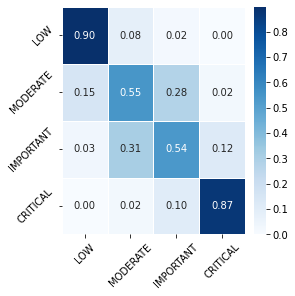

In [36]:
labels = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']

fig, axe = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

cm = np.ndarray(shape=(4,4), dtype=float)
begin = 0
for row in range(4):           
    cm[row, ] = cms_upper[ACTIVE_SUPER][GB][begin:begin + 4]
    begin += 4

axe = sns.heatmap(cm, ax=axe, annot=True, fmt=".2f", linewidths=.5, cmap=plt.cm.Blues, 
                  yticklabels=labels, xticklabels=labels, cbar=True)

axe.set_xticklabels(axe.get_xticklabels(), rotation=45)
axe.set_yticklabels(axe.get_yticklabels(), rotation=45)
plt.savefig('cm-gb-super.pdf', format='pdf', dpi=1200)
plt.show()

## Accuracy graph with AUC

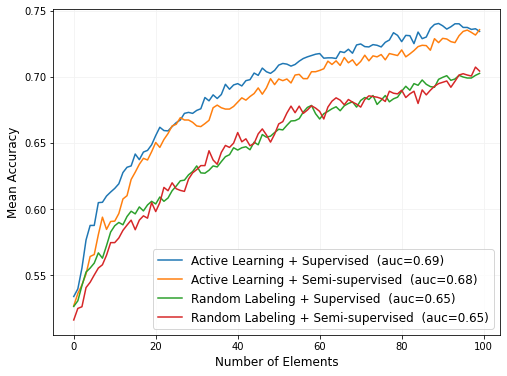

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

techs = [ACTIVE_SEMI, RANDOM_SEMI, ACTIVE_SUPER, RANDOM_SUPER]

names = [ 
    'Active Learning + Semi-supervised', 
    'Random Labeling + Semi-supervised',
    'Active Learning + Supervised',
    'Random Labeling + Supervised'
]

learner = GB

results = list()

for tech, name in zip(techs, names):
    _auc = auc(np.linspace(0, 1, 100), accs[tech][learner])    
    results.append((_auc, f'{name}  (auc={_auc:.2f})', accs[tech][learner]))

results = sorted(results, key=lambda tup: tup[0], reverse=True)

for _, legend, acc_list in results:
    ax.plot([i for i in range(100)], acc_list, label=legend)

ax.set_xlabel('Number of Elements', size=12)
ax.set_ylabel('Mean Accuracy', size=12)
ax.grid(color='0.95')
ax.legend(loc=4, prop={'size': 12})

plt.savefig('gb-curve.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()